In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyomo.environ as pyo
from IPython.display import Markdown, display
from pyomo.environ import value

# Solving the Rectangles Packing problem with Classiq

## Rectangle Packing 

**The rectangle packing problem is a classic optimization problem where the goal is to pack a set of given rectangles into a larger container rectangle (or bin) in a way that optimizes certain criteria, such as minimizing the total area used, minimizing wasted space, or maximizing the number of rectangles packed. This problem arises in various practical applications, including logistics (loading containers), manufacturing (cutting stock problems), and electronics (VLSI design).**

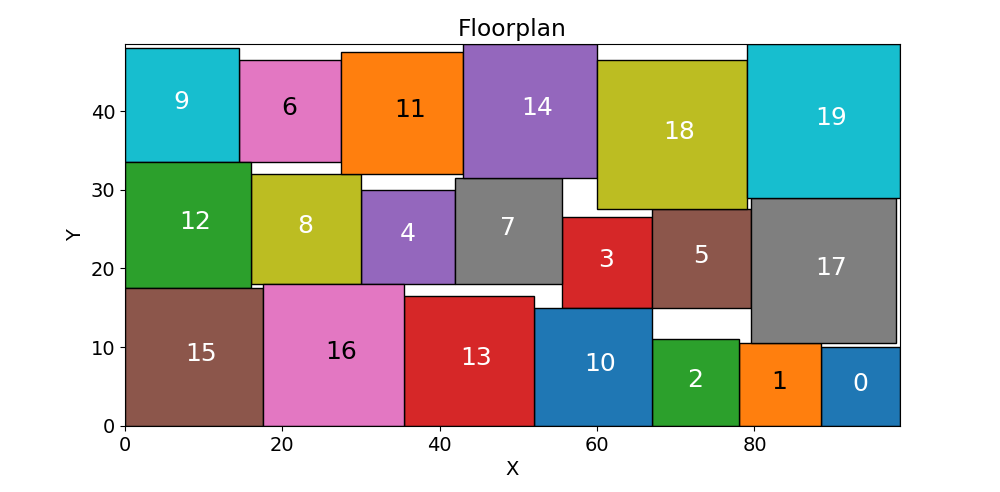


***<div class="alert alert-success">In this demonstration, we explore the rectangle packing problem where the objective is to arrange N rectangles of different sizes  within a fixed grid container. The challenge lies in efficiently positioning these rectangles to maximize space utilization without overlap. This problem is a common optimization task with applications in areas such as logistics and manufacturing. </div>***

## The Quantum Approximate Optimization Algorithm (QAOA) for rectangles packing

The rectangle packing problem is NP-hard, meaning that as the number of rectangles increases, the computational effort required grows exponentially for classical algorithms. QAOA offers a potential exponential speedup.

Solving the rectangles problem using QAOA holds promise due to the potential computational advantages offered by quantum computing, particularly in tackling the complexity and size of the problem more efficiently than classical methods.

## Solving QAOA with Classiq

Classiq allows expressing a given optimization challenge in 3 simple steps:

1. **_Define the optimization problem_**

    Classiq seamlessly integrate a well known open source **classical** optimization modeling language with a diverse set of optimization capabilities (Pyomo).

    The Pyomo language supports a wide variety of problem types, such as integer linear programming, quadratic programming, graph theory problems, SAT problems, and many more.

2. **_Plug the optimization model into Classiq_**

    The **Combinatorial Optimization engine fully translates the Pyomo model to Qmod** which is then synthesized into a Quantum Program object that encapsulates the QAOA implementation. The Quantum Program can be visually analyzed for debugging and even educational purposes. 
    
3. **_Execute and analyze results_**

    Classiq allows **execution of the Quantum Program** on any leading quantum backend - hardware or simulator.




## 1.  Define the optimization problem

We will first define a **classical** optimization model:
We encode the rectangles positions into a binary variable that represents the rectangle id and its position within a given 2-dimensional container grid.
We require that each rectangle is placed at most once and that rectangles are placed within the container grid and do not overlap.

1. *Sets and Parameters:*
    - `container_width` and `container_height` define the dimensions of the container.
    - `rectangles` is a list of tuples, where each tuple represents the width and height of a rectangle.
    - `num_rectangles` is the number of rectangles.
2. *Variables:*
    - `model.place` is a a 3-dimensional binary variable to represent whether a rectangle r bottom left corner is placed at position (i, j).
3. *Constraints:*
    - `one_place_rule` ensues each rectangle is placed at most once.
    - `within_container_rule` ensure each rectangle fits within the container.
    - `non_overlap_rule` ensures that rectangles do not overlap.
4. *Objective Function:*
    - In our example the objective is to maximize the number of rectangles placed.


***This is a basic model and can be extended to include more sophisticated features like rotation of rectangles, different objective functions, or more complex constraints.***



### Parameters

We will define a toy model of 3 rectangles packed into an 8 pixel grid container:


In [2]:
# Dimensions of the container (width and height)
CONTAINER_WIDTH = 4
CONTAINER_HEIGHT = 2

# List of rectangles with (width, height) tuples
RECTANGLES = [(1, 1), (2, 2), (2, 1)]

### Optimization Model

In [3]:
from pyomo.environ import (
    Binary,
    ConcreteModel,
    Constraint,
    Objective,
    RangeSet,
    SolverFactory,
    Var,
)


def define_rectangkes_packing_model(rectangles, container_width, container_height):
    # Number of rectangles
    num_rectangles = len(rectangles)

    # Create a model
    model = ConcreteModel()

    # Sets for rectangles and grid positions
    model.R = RangeSet(0, num_rectangles - 1)
    model.W = RangeSet(0, container_width - 1)
    model.H = RangeSet(0, container_height - 1)

    # Binary variable: 1 if rectangle r is placed at position (i, j), 0 otherwise
    model.place = Var(model.R, model.W, model.H, domain=Binary)

    # Constraints to ensure each rectangle is placed at most once
    def one_place_rule(model, r):
        return sum(model.place[r, i, j] for i in model.W for j in model.H) <= 1

    model.one_place = Constraint(model.R, rule=one_place_rule)

    # Constraints to ensure rectangles do not overlap -  we ensure for each coordinate that it is occupied by at most 1 rectangle
    def non_overlap_rule(model, i, j):
        return (
            sum(
                model.place[r, i2, j2]
                for r in model.R
                for i2 in range(i - rectangles[r][0] + 1, i + 1)
                for j2 in range(j - rectangles[r][1] + 1, j + 1)
                if i2 >= 0 and j2 >= 0
            )
            <= 1
        )

    model.non_overlap = Constraint(model.W, model.H, rule=non_overlap_rule)

    # Constraints to ensure each rectangle is within the container
    def within_container_rule(model, r, i, j):
        if (
            i + rectangles[r][0] > container_width
            or j + rectangles[r][1] > container_height
        ):
            return model.place[r, i, j] == 0
        return Constraint.Skip

    model.within_container = Constraint(
        model.R, model.W, model.H, rule=within_container_rule
    )

    # Objective function: maximize the number of placed rectangles
    model.obj = Objective(
        expr=-sum(
            model.place[r, i, j] for r in model.R for i in model.W for j in model.H
        ),
        sense=pyo.minimize,
    )

    return model

In [4]:
model = define_rectangkes_packing_model(RECTANGLES, CONTAINER_WIDTH, CONTAINER_HEIGHT)

In [5]:
model.pprint()

3 RangeSet Declarations
    H : Dimen=1, Size=2, Bounds=(0, 1)
        Key  : Finite : Members
        None :   True :   [0:1]
    R : Dimen=1, Size=3, Bounds=(0, 2)
        Key  : Finite : Members
        None :   True :   [0:2]
    W : Dimen=1, Size=4, Bounds=(0, 3)
        Key  : Finite : Members
        None :   True :   [0:3]

1 Var Declarations
    place : Size=24, Index=R*W*H
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 1) :     0 :  None :     1 : False :  True : Binary
        (1,

## 2. Plug into Classiq

### Initialize combinatorial optimization engine

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):



In [6]:
from classiq import *
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=10, penalty_energy=100)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [3]:


In [7]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=1)

### Pluging-in the Pyomo model into the combinatorial optimization engine constructs the Qmod:

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:



In [8]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [9]:
from classiq.execution import ClassiqBackendPreferences

qmod = set_execution_preferences(
    qmod,
    num_shots=10000,
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

## 3. Solve and Analyze

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:




*<div class="alert alert-info" role="alert">Synthesize and view our QAOA circuit:</div>*

In [10]:
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/39FizAtlqQsR6aEGiu6c5G0R9vD


https://platform.classiq.io/circuit/39FizAtlqQsR6aEGiu6c5G0R9vD?login=True&version=17

*<div class="alert alert-info" role="alert">Execute QAOA:</div>*

We now solve the problem by calling the `execute` function on the quantum program we have generated:


In [11]:
result = execute(qprog).result_value()

We can check the convergence of the run:

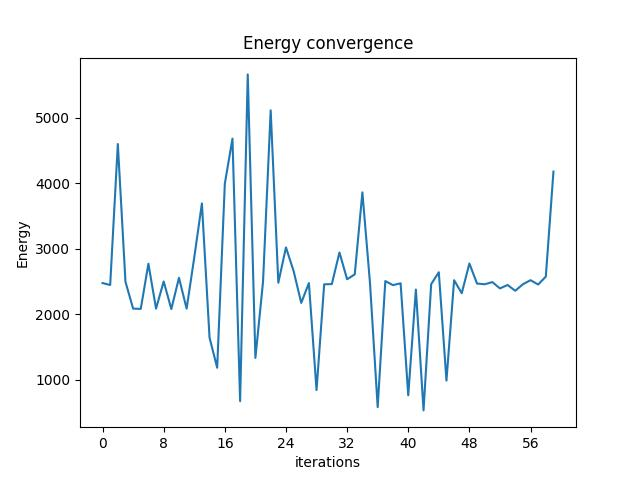

In [12]:
result.convergence_graph

We can also examine the statistics of the algorithm:


In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    model, vqe_result=result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
75,0.0010,-3.0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",10
80,0.0009,-3.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",9
27,0.0014,-3.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",14
285,0.0005,-3.0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",5
223,0.0006,-3.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",6


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

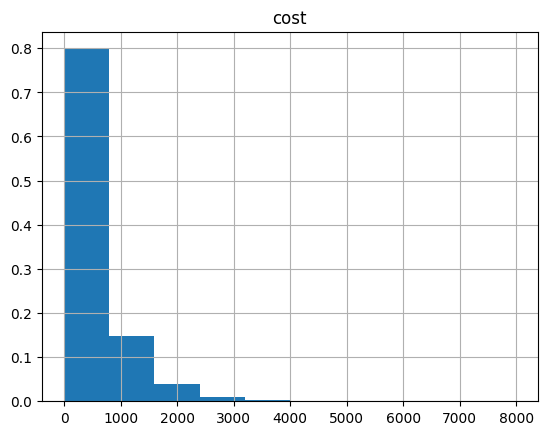

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

### Visualize the results

In order to visualize the `best_solution` as a floor plan we construct few simple post processing utilities.

To save qubits, the combinatorinal optimization engine creates a quantum program with qubits only correlating to binary variables that are not constraint to known fixed values. First, lets create a function that extracts the qubit indexes of variables that have no difference between the upper and lower bound of the constraints:   

In [16]:
def extract_no_boundries_qubit_indexes(model):
    no_qubits_indexes = []
    for c in model.component_objects(Constraint, active=True):
        cdata = getattr(model, c.name)
        for index in cdata:
            lb = value(cdata[index].lower)
            ub = value(cdata[index].upper)
            if lb == ub:
                no_qubits_indexes.append(index)
    return no_qubits_indexes

Since the `best_solution` appends zeros into the the executed quantum program solution for each variable with no constraint boundary, we will use the `extract_no_boundries_qubit_indexes` above to "reorganize" the solution vector so we can properly visualize it:

In [17]:
def prepare_solution_for_floorplan_visual(best_solution, no_qubits_indexes):
    best_solution_index_count = 0
    solution = {}
    for r in model.R:
        for w in model.W:
            for h in model.H:
                if (r, w, h) not in no_qubits_indexes:
                    solution[(r, w, h)] = best_solution[best_solution_index_count]
                    best_solution_index_count += 1
                else:
                    solution[(r, w, h)] = 0
    return solution


def place_rectangles(solution):
    placement = {}
    for r in model.R:
        for i in model.W:
            for j in model.H:
                if solution[(r, i, j)] == 1:
                    placement[r] = (i, j)
    return placement

We can now run the floorplan visualization function:

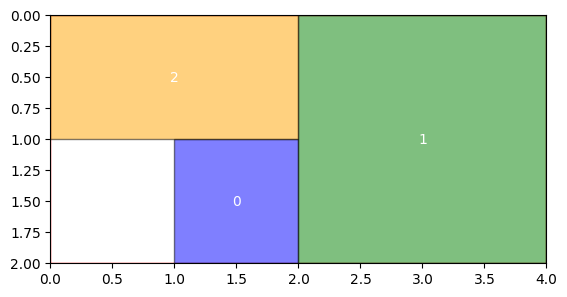

In [18]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt


# Function to visualize the rectangle packing solution
def visualize_packing(container_width, container_height, rectangles, placement):
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, container_width)
    ax.set_ylim(0, container_height)

    # Draw the container
    container = patches.Rectangle(
        (0, 0),
        container_width,
        container_height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(container)

    # Draw each rectangle
    colors = [
        "blue",
        "green",
        "orange",
        "purple",
        "yellow",
    ]  # Add more colors if needed
    for r, (i, j) in placement.items():
        width, height = rectangles[r]
        rect = patches.Rectangle(
            (i, j),
            width,
            height,
            linewidth=1,
            edgecolor="black",
            facecolor=colors[r % len(colors)],
            alpha=0.5,
        )
        ax.add_patch(rect)
        plt.text(
            i + width / 2,
            j + height / 2,
            f"{r}",
            ha="center",
            va="center",
            color="white",
        )

    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().invert_yaxis()  # Invert y axis to match the typical matrix/grid representation
    # plt.grid(True)
    plt.show()


# Visualize the solution
visualize_packing(
    CONTAINER_WIDTH,
    CONTAINER_HEIGHT,
    RECTANGLES,
    place_rectangles(
        prepare_solution_for_floorplan_visual(
            best_solution, extract_no_boundries_qubit_indexes(model)
        )
    ),
)

### Solve classically, visualize results and compare:

Running the following requires to install the classical solver with 'brew install glpk'

In [19]:
"""
# Create a solver
solver = SolverFactory('glpk')


# Solve the model
solver.solve(model)

# Display results
for r in model.R:
    placed = [(i, j) for i in model.W for j in model.H if model.place[r, i, j].value == 1]
    if placed:
        print(f"Rectangle {RECTANGLES[r]} placed at position {placed[0]}")
    else:
        print(f"Rectangle {r} not placed")

import matplotlib.pyplot as plt
import matplotlib.patches as patches


placement = {}
for r in model.R:
    for i in model.W:
        for j in model.H:
            if model.place[r, i, j].value == 1:
                placement[r] = (i, j)
                


# Visualize the solution
visualize_packing(CONTAINER_WIDTH,CONTAINER_HEIGHT, RECTANGLES, placement)
"""

'\n# Create a solver\nsolver = SolverFactory(\'glpk\')\n\n\n# Solve the model\nsolver.solve(model)\n\n# Display results\nfor r in model.R:\n    placed = [(i, j) for i in model.W for j in model.H if model.place[r, i, j].value == 1]\n    if placed:\n        print(f"Rectangle {RECTANGLES[r]} placed at position {placed[0]}")\n    else:\n        print(f"Rectangle {r} not placed")\n\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\n\n\nplacement = {}\nfor r in model.R:\n    for i in model.W:\n        for j in model.H:\n            if model.place[r, i, j].value == 1:\n                placement[r] = (i, j)\n\n\n\n# Visualize the solution\nvisualize_packing(CONTAINER_WIDTH,CONTAINER_HEIGHT, RECTANGLES, placement)\n'